In [1]:
import os
print(os.getcwd())
print(os.listdir())

/Users/raniacharkaoui/Desktop/MA1/idc_in_breast_cancer
['DeepLearning_BreastCancer.ipynb', 'breast-histopathology-images.ipynb', '.DS_Store', 'predicting_idc_in_breast_cancer_histology_images.ipynb', 'projet_in_pytorch.ipynb', 'results', 'Projet_final.ipynb', 'model_results.png', 'X.npy', 'Y.npy', '.ipynb_checkpoints', 'model_results2.png', 'data']


In [4]:
import time, copy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
print(f"torch version : {torch.__version__}")
print(f"cuda available ? {torch.cuda.is_available()}")
print(f"cuda version : {torch.version.cuda}")

torch version : 1.8.0
cuda available ? False
cuda version : None


In [6]:
images = os.listdir('data')
print(images[:10])

['9036', '10268', '10257', '8913', '13613', '8914', '15510', '10259', '16165', '10292']


In [7]:
data = []

for n in os.listdir("data/"):
    if n != "DeepLearning_BreastCancer.ipynb" and n != ".DS_Store" and n != ".ipynb_checkpoints" and n !='IDC_regular_ps50_idx5':
        for d in os.listdir("data/" + n): #0 or 1
            if d != ".DS_Store":
                for f in os.listdir("data/" + n + "/" +str(d)+"/"): #png file
                    data.append("data/{}/{}/{}".format(n,d,f))

print(len(data))
print(data[:10])

277524
['data/9036/0/9036_idx5_x1051_y2401_class0.png', 'data/9036/0/9036_idx5_x2951_y951_class0.png', 'data/9036/0/9036_idx5_x3001_y1451_class0.png', 'data/9036/0/9036_idx5_x3051_y801_class0.png', 'data/9036/0/9036_idx5_x951_y1901_class0.png', 'data/9036/0/9036_idx5_x2251_y751_class0.png', 'data/9036/0/9036_idx5_x1901_y401_class0.png', 'data/9036/0/9036_idx5_x3201_y1101_class0.png', 'data/9036/0/9036_idx5_x3351_y1251_class0.png', 'data/9036/0/9036_idx5_x2051_y2551_class0.png']


In [8]:
f = pd.Series(data)
# print(f[:10])
i = f.apply(lambda x: x.split("_")[0].split("/")[3]).astype('int')
# print(i[:10])
x = f.apply(lambda x: x.split("_")[2][1:]).astype('int')
# print(x[:10])
y = f.apply(lambda x: x.split("_")[3][1:]).astype('int')
# print(y[:10])
c = f.apply(lambda x: x.split("_")[4][5]).astype('int64')
# print(c[:10])
# print(len(f))
df = pd.DataFrame({'filename': f, 'id': i, 'x':x, 'y':y,'class':c})
print(df.head())

                                       filename    id     x     y  class
0  data/9036/0/9036_idx5_x1051_y2401_class0.png  9036  1051  2401      0
1   data/9036/0/9036_idx5_x2951_y951_class0.png  9036  2951   951      0
2  data/9036/0/9036_idx5_x3001_y1451_class0.png  9036  3001  1451      0
3   data/9036/0/9036_idx5_x3051_y801_class0.png  9036  3051   801      0
4   data/9036/0/9036_idx5_x951_y1901_class0.png  9036   951  1901      0


In [9]:
# Removing imbalance in data by downsampling
df_cut = df.copy()

imbalance = sum(df["class"]==0) - sum(df["class"]==1)

to_cut = df_cut.loc[df_cut["class"]==0].sample(n=imbalance)

df_cut = df_cut.loc[~df_cut["filename"].isin(to_cut["filename"])]
print(df_cut.head())

                                       filename    id     x     y  class
0  data/9036/0/9036_idx5_x1051_y2401_class0.png  9036  1051  2401      0
5   data/9036/0/9036_idx5_x2251_y751_class0.png  9036  2251   751      0
6   data/9036/0/9036_idx5_x1901_y401_class0.png  9036  1901   401      0
7  data/9036/0/9036_idx5_x3201_y1101_class0.png  9036  3201  1101      0
8  data/9036/0/9036_idx5_x3351_y1251_class0.png  9036  3351  1251      0


In [10]:
len(df_cut)

157572

In [11]:
print(len(df["id"].unique()), "patients")

279 patients


In [12]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  277524 non-null  object
 1   id        277524 non-null  int64 
 2   x         277524 non-null  int64 
 3   y         277524 non-null  int64 
 4   class     277524 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 10.6+ MB
None
                  id              x              y          class
count  277524.000000  277524.000000  277524.000000  277524.000000
mean    11811.994757    1620.891433    1207.814005       0.283889
std      2354.814020     813.975056     628.163551       0.450884
min      8863.000000       1.000000       1.000000       0.000000
25%      9322.000000    1001.000000     701.000000       0.000000
50%     12750.000000    1601.000000    1151.000000       0.000000
75%     13458.000000    2201.000000    1651.000000       1.000000
max     16896.000000    4001.0000

In [13]:
print((df["class"] == 0).sum())
print((df["class"] == 1).sum())

198738
78786


Show images

In [14]:
sample = df.loc[df["class"]==0].sample(n=10)
sample = sample.append(df.loc[df["class"]==1].sample(n=10)).reset_index(drop=True)
print(sample)

                                          filename     id     x     y  class
0   data/13401/0/13401_idx5_x2301_y1701_class0.png  13401  2301  1701      0
1    data/10308/0/10308_idx5_x651_y1651_class0.png  10308   651  1651      0
2   data/15472/0/15472_idx5_x3451_y1151_class0.png  15472  3451  1151      0
3    data/16551/0/16551_idx5_x1851_y901_class0.png  16551  1851   901      0
4   data/10300/0/10300_idx5_x1201_y1351_class0.png  10300  1201  1351      0
5    data/13689/0/13689_idx5_x801_y1451_class0.png  13689   801  1451      0
6   data/10279/0/10279_idx5_x2401_y1951_class0.png  10279  2401  1951      0
7   data/12932/0/12932_idx5_x2401_y2551_class0.png  12932  2401  2551      0
8   data/13024/0/13024_idx5_x1501_y1401_class0.png  13024  1501  1401      0
9       data/9173/0/9173_idx5_x701_y851_class0.png   9173   701   851      0
10  data/10302/1/10302_idx5_x2051_y1701_class1.png  10302  2051  1701      1
11     data/8980/1/8980_idx5_x801_y1151_class1.png   8980   801  1151      1

                                          filename     id     x     y  class
0     data/12867/0/12867_idx5_x451_y651_class0.png  12867   451   651      0
1   data/12878/0/12878_idx5_x2851_y2051_class0.png  12878  2851  2051      0
2     data/9123/0/9123_idx5_x3001_y1351_class0.png   9123  3001  1351      0
3    data/10260/0/10260_idx5_x2151_y901_class0.png  10260  2151   901      0
4    data/10303/0/10303_idx5_x251_y1651_class0.png  10303   251  1651      0
5       data/8913/0/8913_idx5_x501_y101_class0.png   8913   501   101      0
6   data/14192/0/14192_idx5_x2351_y1701_class0.png  14192  2351  1701      0
7    data/15902/0/15902_idx5_x901_y1251_class0.png  15902   901  1251      0
8     data/9325/0/9325_idx5_x1851_y1851_class0.png   9325  1851  1851      0
9    data/14190/0/14190_idx5_x3451_y951_class0.png  14190  3451   951      0
10  data/12749/1/12749_idx5_x2451_y1451_class1.png  12749  2451  1451      1
11  data/12821/1/12821_idx5_x1051_y1101_class1.png  12821  1051  1101      1

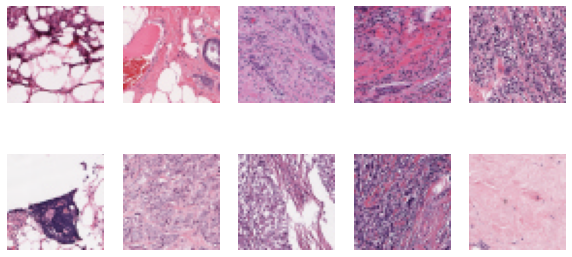

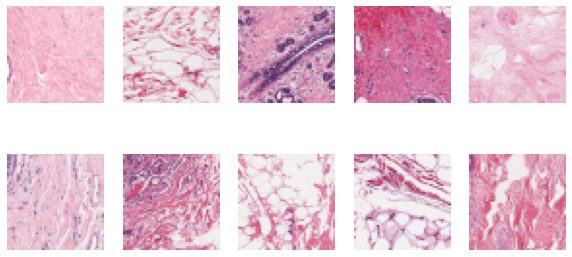

In [15]:
from skimage.io import imread
sample = df.loc[df["class"]==0].sample(n=10)
sample = sample.append(df.loc[df["class"]==1].sample(n=10)).reset_index(drop=True)
print(sample)
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(top = 0.5)

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.axis("off")
    plt.imshow(imread(sample.loc[10+i, "filename"]))


plt.savefig('results/positive.png', transparent=True)

plt.show()

fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(top = 0.5)

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.axis("off")
    plt.imshow(imread(sample.loc[i, "filename"]))


plt.savefig('results/negative.png', transparent=True)

plt.show()

### Create Dataset

In [16]:
class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.img_labels = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, "filename"])
        img = Image.open(img_path).convert('RGB')
        # img = read_image(img_path)
        

        label = self.img_labels.loc[idx, "class"]
        if self.transform:
            img = self.transform(img)
        
#         target = torch.tensor(self.img_labels.loc[idx, "class"])
#         label = torch.nn.functional.one_hot(target, num_classes=2)

        return img, label

In [17]:
train_transforms = transforms.Compose([
        transforms.Resize((50, 50)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
        transforms.Resize((50, 50)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [19]:
train_df, test_df = train_test_split(df_cut, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [20]:
training_data = CustomImageDataset(train_df, '.', transform=train_transforms)
val_data = CustomImageDataset(val_df, '.', transform=test_transforms)
test_data = CustomImageDataset(test_df, '.', transform=test_transforms)

print(len(training_data))
print(len(val_data))
print(len(test_data))

100845
25212
31515


In [21]:
batch_size = 64

In [22]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 50, 50])
Labels batch shape: torch.Size([64])
torch.Size([3, 50, 50])
tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0])


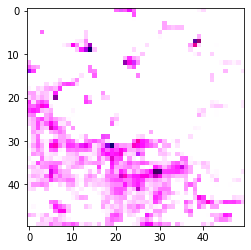

In [23]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
# print(type(train_features))
# print(train_features)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
print(img.shape)
label = train_labels[0]
print(train_labels)

grid = utils.make_grid(train_features[:4], 2)

plt.figure()
plt.imshow(img.permute(1,2,0)) #grid.permute(1, 2, 0)
plt.show()

In [24]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) #nb channel In, nb channel Out, Kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 9 * 9, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2592, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


check shapes

In [25]:
train_features, train_labels = next(iter(train_dataloader))
model(train_features)

tensor([[-3.8186e-02, -3.7004e-03],
        [-4.8744e-02, -3.9329e-03],
        [-4.1337e-02,  1.7543e-02],
        [-5.9458e-02,  6.0434e-03],
        [-5.4826e-02,  1.7485e-02],
        [-4.1533e-02,  8.7457e-03],
        [-4.6748e-02,  8.3257e-03],
        [-3.7116e-02, -1.6257e-03],
        [-5.4262e-02,  3.6092e-03],
        [-3.4487e-02,  1.5861e-02],
        [-4.4693e-02, -3.7836e-03],
        [-5.1528e-02,  2.3640e-03],
        [-5.7537e-02,  1.0182e-02],
        [-5.0976e-02,  4.9975e-03],
        [-4.7740e-02, -1.0373e-02],
        [-5.3877e-02,  1.5525e-02],
        [-6.0303e-02, -2.5501e-03],
        [-6.1396e-02, -1.0448e-02],
        [-6.3018e-02,  1.6912e-02],
        [-4.3189e-02,  2.6189e-03],
        [-5.1764e-02,  9.2136e-03],
        [-6.0308e-02, -2.9661e-03],
        [-4.8468e-02,  1.0445e-02],
        [-5.6050e-02,  7.7254e-03],
        [-4.7645e-02,  1.5357e-02],
        [-6.3343e-02,  4.9079e-03],
        [-8.7692e-02, -7.3266e-04],
        [-4.6460e-02,  5.752

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## training

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        start = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, data in enumerate(dataloaders[phase]):

                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / datasets_sizes[phase]
                epoch_acc = running_corrects.double() / datasets_sizes[phase]

                # print statistics
                print_per_phase = 5
                if i % ((datasets_sizes[phase]//batch_size)//print_per_phase) == 0 : # print "print_per_phase" times statistics per phase per epoch 
                    print(f'{phase} {100*(i*batch_size)/datasets_sizes[phase]:.0f}% - loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')
                    running_loss = 0.0


            if phase == 'train':
                scheduler.step()
            
            # tensorboard.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
            # tensorboard.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)
            

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
          
        end = time.time()
        print(f'\ntime : {end-start}\n')

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [28]:
dataloaders = {"train": train_dataloader, "val": val_dataloader}
datasets_sizes = {"train": len(training_data), "val": len(val_data)}
print(len(training_data))
print(len(val_data))
print((len(val_data)//batch_size)//10)

100845
25212
39


In [29]:
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
trained_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------
train 0% - loss: 0.0004 acc: 0.0003
train 20% - loss: 0.1219 acc: 0.1304
train 40% - loss: 0.0962 acc: 0.2871
train 60% - loss: 0.0933 acc: 0.4451
train 80% - loss: 0.0934 acc: 0.6035
train 100% - loss: 0.0921 acc: 0.7620
val 0% - loss: 0.0011 acc: 0.0021
val 20% - loss: 0.0897 acc: 0.1598
val 40% - loss: 0.0884 acc: 0.3182
val 59% - loss: 0.0883 acc: 0.4773
val 79% - loss: 0.0883 acc: 0.6356
val 99% - loss: 0.0905 acc: 0.7945

time : 80.92746353149414

Epoch 2/15
----------
train 0% - loss: 0.0003 acc: 0.0005
train 20% - loss: 0.0904 acc: 0.1592
train 40% - loss: 0.0903 acc: 0.3188
train 60% - loss: 0.0899 acc: 0.4784
train 80% - loss: 0.0898 acc: 0.6386
train 100% - loss: 0.0885 acc: 0.7991
val 0% - loss: 0.0011 acc: 0.0021
val 20% - loss: 0.0859 acc: 0.1619
val 40% - loss: 0.0864 acc: 0.3218
val 59% - loss: 0.0872 acc: 0.4816
val 79% - loss: 0.0872 acc: 0.6399
val 99% - loss: 0.0867 acc: 0.7983

time : 63.259243965148926

Epoch 3/15
----------
train 0% - loss: 

In [31]:
def test_model(model):
    start = time.time()
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        loss = running_loss / len(test_data)
        acc = running_corrects.double() / len(test_data)
    
    end = time.time()
    print(f'Loss: {loss:.4f} Accuracy: {acc:.4f}')
    print(f'\ntime : {end-start}\n')

In [32]:
test_model(model)

Loss: 0.3595 Accuracy: 0.8469

time : 19.112000465393066



## one iteration

In [241]:
optimizer.zero_grad()
train_features, train_labels = next(iter(train_dataloader))
train_features = train_features
train_labels = train_labels
train_features = train_features.to(device)
train_labels = train_labels.to(device)
print(f"Feature batch shape: {train_features.size()}")
outputs = model(train_features)
# print(outputs)
# print(train_labels)
print(f"Output batch shape: {outputs.shape}")
print(f"Labels batch shape: {train_labels.shape}")
_, preds = torch.max(outputs, 1)
print(f"Preds batch shape: {preds.shape}")
# print(preds)
loss = criterion(outputs, train_labels)
# print(f"Loss batch shape: {preds.shape}")
loss.backward()
optimizer.step()

Feature batch shape: torch.Size([64, 3, 50, 50])
Output batch shape: torch.Size([64, 2])
Labels batch shape: torch.Size([64])
Preds batch shape: torch.Size([64])


Preds batch shape: torch.Size([64])
Loss batch shape: torch.Size([64])
